On the sdf login node
```
[youtsumi@sdf-login02 u]$ source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/loadLSST.bash                                                                                                        [89/89]
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ setup lsst_distrib
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ jupyter lab
```

Needs an ssh tunnel in a separate window

In [1]:
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+78f87bf5bb 	w_latest w_2021_51 current setup


In [2]:
import sys
sys.path.append("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python/mixcoatl/characterizeSpots.py:136: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def run(self, exposure, exposureIdInfo=None):


In [4]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/"
butler = Butler(repo_path)

In [6]:
collections="u/youtsumi/Run5/run_R03_S12/spot"
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [7]:
print(registry)

PostgreSQL@rubin:bot_data_w_2021_43


In [8]:
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/calib/unbounded
LSSTCam/raw/all
LSSTCam/photodiode/all
u/snyder18/crosstalk_13169/sbias/20211215T191900Z
u/snyder18/crosstalk_13175/sbias/20211217T211636Z
u/snyder18/crosstalk_13186/sbias/20211217T225138Z
u/snyder18/crosstalk_13169/crosstalk_spot/20211218T003408Z
u/snyder18/crosstalk_13175/crosstalk_spot/20211218T225100Z
u/snyder18/crosstalk_13186/crosstalk_spot/20211220T023605Z
u/snyder18/crosstalk_13198/sbias/20211220T182307Z
u/snyder18/crosstalk_13200/sbias/20211220T215856Z
u/snyder18/crosstalk_13200/crosstalk_spot/20211220T223117Z
u/snyder18/crosstalk_13224/sbias/20211221T223805Z
u/snyder18/crosstalk_13224/crosstalk_spot/20211221T224715Z
u/abrought/run_13141/sbias/20211223T071924Z
u/abrought/run_13141/sflat/20211223T080759Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T171539Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T180251Z
u/youtsumi/Run5/run_R02_S00/sbias/20211223T180452Z
u/youtsumi/Run5/run_R02_S00/sdark/20211223T183026Z
u/abrought/run_13141/sflat/20211223T183057Z
u/yout

In [9]:
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3131869 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('photodiode', {band, instrument, physical_filter, exposure}, AstropyTable)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
700 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instru

In [ ]:
where = """
instrument='LSSTCam'
and detector=23
"""
#and exposure.observation_type = 'spot'
#and exposure.science_program IN ('13232','13234')

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs[:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002419/MC_C_20211223_002419_R03_S12.fits(MC_C_20211223_002419): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002419/MC_C_20211223_002419_R03_S12.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002285/MC_C_20211223_002285_R03_S12.fits(MC_C_20211223_002285): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002285/MC_C_20211223_002285_R03_S12.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002290/MC_C_20211223_002290_R03_S12.fits(MC_C_20211223_002290): Unable to determine the filter
/sdf/group/

In [20]:
from astropy.table import vstack, join
faint = []
for aresult in results:
    if aresult["md"]["EXPTIME"]>13:
        continue
    faint.append(aresult["src"].asAstropy())
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0) &
        (mean_data_table["base_PixelFlags_flag"]==False) &
        (mean_data_table["base_PsfFlux_flag"]==False) &
        (mean_data_table["base_SdssCentroid_flag"]==False) &
        (mean_data_table["base_CircularApertureFlux_70_0_flag_apertureTruncated"]==False) &
        (mean_data_table["spotgrid_x"]<3800) &
        (mean_data_table["spotgrid_y"]<3800) &
        (mean_data_table["spotgrid_x"]>200) &
        (mean_data_table["spotgrid_y"]>200)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0-ext/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<Table length=2401>
   id   coord_ra coord_dec  parent base_SdssCentroid_x base_SdssCentroid_y ... base_FootprintArea_value     spotgrid_y         spotgrid_x     spotgrid_normalized_dy  spotgrid_normalized_dx spotgrid_index
          rad       rad                    pix                 pix         ...           pix                                                                                                               
float64 float64   float64  float64       float64             float64       ...         float64               float64            float64              float64                 float64             int32     
------- -------- --------- ------- ------------------- ------------------- ... ------------------------ ------------------ ------------------ ---------------------- ----------------------- --------------
    3.0      nan       nan     0.0  1667.3153057515606  1354.9471733060986 ...                    317.0  1354.022275301616 1666.6476048282304   0.013151679218692352    0.011797213683856689              0
   15.0      nan       nan     0.0  1661.3329231130258  1420.6730316909768 ...                    317.0  1419.725923460392 1660.6677067541518   0.013706729818904598     0.01098333858005903              1
   38.0      nan       nan     0.0  1655.3215946590913   1486.238434280282 ...                    317.0 1485.4831369038307 1654.6488596709141   0.010692141999014623    0.010689156293539418              2
   72.0      nan       nan     0.0  1649.2670969787341  1551.8562784554915 ...                    317.0   1551.12628598334 1648.7516907656357    0.01027189960604568    0.008863994111262208              3
  109.0      nan       nan     0.0  1643.3144805653833  1617.5887330763924 ...                    317.0 1616.8447339126792 1642.7924572218321   0.010645550255322812    0.008900837038454054              4
  146.0      nan       nan     0.0   1637.375415395891  1683.0738694529664 ...                    317.0  1682.566312747515 1636.8349360945758   0.007247582488427769      0.0087253875591431              5
  183.0      nan       nan     0.0   1631.397513237582  1748.8097471596247 ...                    317.0 1748.2264618399684 1630.9155310932522   0.008083441770600584    0.008038821876112793              6
  219.0      nan       nan     0.0  1625.5315803338185  1814.4084097814741 ...                    317.0  1813.941007705009  1624.969456200494   0.006358766855006482    0.009014552887157634              7
  258.0      nan       nan     0.0  1619.5320276274397  1880.0461068256734 ...                    317.0 1879.6348785360844 1619.0311355344566   0.005536682117630131     0.00813955692754502              8
  295.0      nan       nan     0.0  1613.6738845563211  1945.8213791362634 ...                    317.0 1945.3035368356286   1613.10295091396   0.006743492910462593    0.009085362689535978              9
  333.0      nan       nan     0.0  1607.8609662660976  2011.1627748256797 ...                    317.0  2010.970042243231 1607.1870634137765  0.0015666105416362235    0.010168287219431821             10
  372.0      nan       nan     0.0  1601.6768316625153   2077.022633275712 ...                    317.0  2076.673722427304  1601.232751801405   0.004279100432518779    0.007153567454695479             11
  409.0      nan       nan     0.0   1595.817816532207  2142.5857938518634 ...                    317.0   2142.35511771085 1595.3135873430308   0.002644308674819752     0.00785705560793121             12
  447.0      nan       nan     0.0  1589.8099778930482  2208.3809273136717 ...                    317.0 2208.0421801130997  1589.381527569438   0.004426034730665982    0.006843611880731005             13
  405.0      nan       nan     0.0  1584.1864969258118  2273.7852682495018 ...                    317.0  2273.510782178321 1583.7845099891588   0.003537384161018087    0.005739338374259863             14
  441.5      nan       nan     0.0  1578.2276333018276  2339.4320306893787 ...                    317.0 

In [102]:
exparray = numpy.array([ aresult["md"]["EXPTIME"] for aresult in results ])
exptime=list(set(exparray))

In [22]:
exparray[ numpy.argmin(exparray) ]

1.25

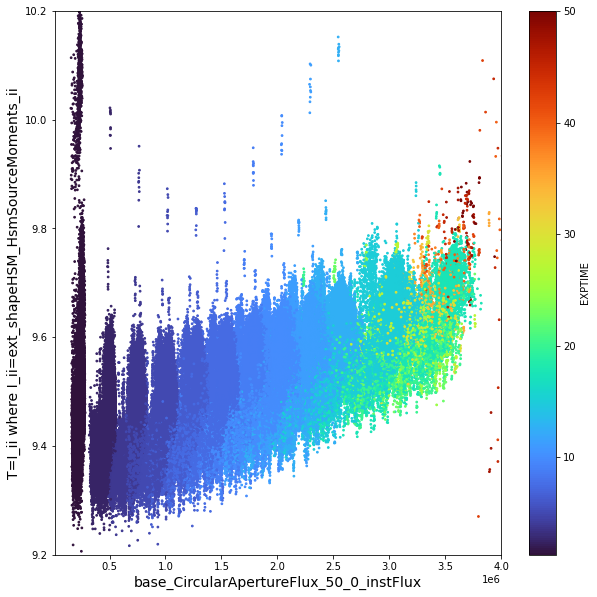

In [106]:
fontsize=14
fig = plt.figure(figsize=(10,10),facecolor="white")

#ykey="ext_shapeHSM_HsmShapeRegauss_sigma"
#ykey="base_SdssShape_xx"
ykey="ext_shapeHSM_HsmSourceMoments_xx"
#y2key="base_SdssShape_yy"
y2key="ext_shapeHSM_HsmSourceMoments_yy"
xkey="base_CircularApertureFlux_50_0_instFlux"
#xkey="base_SdssShape_instFlux"
x = []
y = []
e = []
for aresult in results[:]:
#    cond = ( aresult["src"]["spotgrid_index"]>=0 ) & ( aresult["src"]["spotgrid_normalized_dx"]**2+aresult["src"]["spotgrid_normalized_dy"]**2<0.002**2 )
    cond = ( aresult["src"]["spotgrid_index"]>=0 ) & (aresult["src"]["base_CircularApertureFlux_70_0_instFlux"]>numpy.nanmax(aresult["src"]["base_CircularApertureFlux_70_0_instFlux"])*0.6)
    x.extend(aresult["src"][xkey][cond])
    y.extend((aresult["src"][ykey]+aresult["src"][y2key])[cond])
    e.extend([aresult["md"]["EXPTIME"]]*len(aresult["src"][xkey][cond]))
x=numpy.array(x)
y=numpy.array(y)
plt.scatter(x,y,c=e,s=3,cmap='turbo',alpha=1)
plt.xlabel(xkey,fontsize=fontsize)
plt.ylabel("{}".format("T=I_ii where I_ii=ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
plt.xlim(1e4,0.4e7)
plt.ylim(9.2,10.2)
#plt.ylim(1e4,1e8)
plt.colorbar(label="EXPTIME")
#plt.loglog()
#plt.semilogx()


In [107]:
from astropy.table import vstack, join
faint = [ results[i]["src"].asAstropy() for i in  numpy.where(exparray == exptime[2] )[0] ] ### this determines which one from the faintest we are going to base on
mean_data_table = vstack(faint, join_type='exact')

mean_data_table_by_groups = mean_data_table[ numpy.where(
        (mean_data_table["spotgrid_index"]>=0)
    )].group_by('spotgrid_index')
ref = mean_data_table_by_groups.groups.aggregate(numpy.nanmedian)
ref

<Table length=2257>
   id   coord_ra coord_dec  parent base_SdssCentroid_x base_SdssCentroid_y ... base_FootprintArea_value     spotgrid_y         spotgrid_x      spotgrid_normalized_dy  spotgrid_normalized_dx spotgrid_index
          rad       rad                    pix                 pix         ...           pix                                                                                                                
float64 float64   float64  float64       float64             float64       ...         float64               float64            float64               float64                 float64             int32     
------- -------- --------- ------- ------------------- ------------------- ... ------------------------ ------------------ ------------------ ----------------------- ----------------------- --------------
  147.0      nan       nan     0.0  1631.5138448562386  1748.7471616037767 ...                    317.0 1748.1751094283654 1631.0226738518468     0.00792942624180942     0.00855471509028517              6
  183.0      nan       nan     0.0  1625.6738244352305  1814.3632307445396 ...                    317.0 1813.8595223231205  1625.080677251828    0.006795856272896289    0.009644339823206886              7
  221.0      nan       nan     0.0   1619.709369834466   1879.907836774122 ...                    317.0 1879.5519899691603 1619.1417626409711    0.004598146602478833    0.009056824591288582              8
  255.0      nan       nan     0.0   1613.790557078274  1945.7763350853447 ...                    317.0 1945.2329287257805   1613.24714105044    0.007590940571771767    0.010116166109657489              9
  292.0      nan       nan     0.0  1607.9324932512154  2011.1710874072455 ...                    317.0 2010.9553116509219 1607.2434909389908   0.0022572903951583435    0.010482176612531768             10
  176.0      nan       nan     0.0  1602.3623731326243   1056.650775747174 ...                    317.0 1056.4158275963025  1601.996476614738    0.004375082853793684   0.0063915807183620235             11
  214.5      nan       nan     0.0  1596.5011620262962  1122.2254830583727 ...                    317.0  1122.098877353991   1596.05596458938   0.0026657364423439897    0.007160947286615593             12
  252.5      nan       nan     0.0  1590.4589026392296  1188.0014332032642 ...                    317.0  1187.781927111679  1590.115452564022    0.004384517106665983    0.006208344904236023             13
  290.5      nan       nan     0.0   1584.553188300002   1253.657357294443 ...                    317.0 1253.4649768693669  1584.174940538664    0.003837104270096851    0.005516168630415246             14
  328.5      nan       nan     0.0  1578.5504876419786  1319.2919256815385 ...                    317.0  1319.148026627055  1578.234428513306    0.003072739759339033    0.005397527188769642             15
  366.5      nan       nan     0.0  1572.6328310489032  1385.0342403690497 ...                    317.0  1384.831076384743  1572.293916487948    0.003997330533290433    0.005531626185932538             16
  405.0      nan       nan     0.0  1566.7874062102012   1450.590839514848 ...                    317.0 1450.5142220159537   1566.35340446259   0.0016253848962160828    0.006485783033763977             17
  442.0      nan       nan     0.0  1560.7995701419256   1516.417681243306 ...                    317.0  1516.197486001586 1560.4128924372321   0.0039545316401711494    0.005616051352300335             18
  481.5      nan       nan     0.0  1554.9953368821164  1582.0105968640473 ...                    317.0 1581.8807499872185 1554.4723804118742    0.002542344802433749    0.007880484090950775             19
  521.0      nan       nan     0.0  1548.9494107883306   1647.700704112944 ...                    317.0 1647.5640139728512 1548.5318683865162   0.0026143857891324602     0.00679659107136627             20
  559.0      nan       nan     0.0  1543.0410038972886   1713.412583009817 ...       

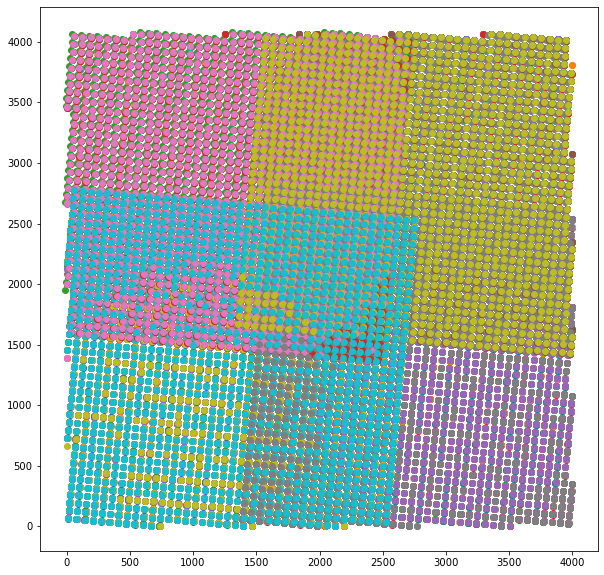

In [52]:
#pylab.scatter(
#    results[0]["src"]["spotgrid_x"],
#    results[0]["src"]["spotgrid_y"]
#)

fig = plt.figure(figsize=(10,10))

for i in range(100):
    pylab.scatter(
        results[i]["src"]["spotgrid_y"],
        results[i]["src"]["spotgrid_x"]
    )

#spotgrid_y	spotgrid_x	spotgrid_normalized_dy	spotgrid_normalized_dx	


<Figure size 720x720 with 0 Axes>

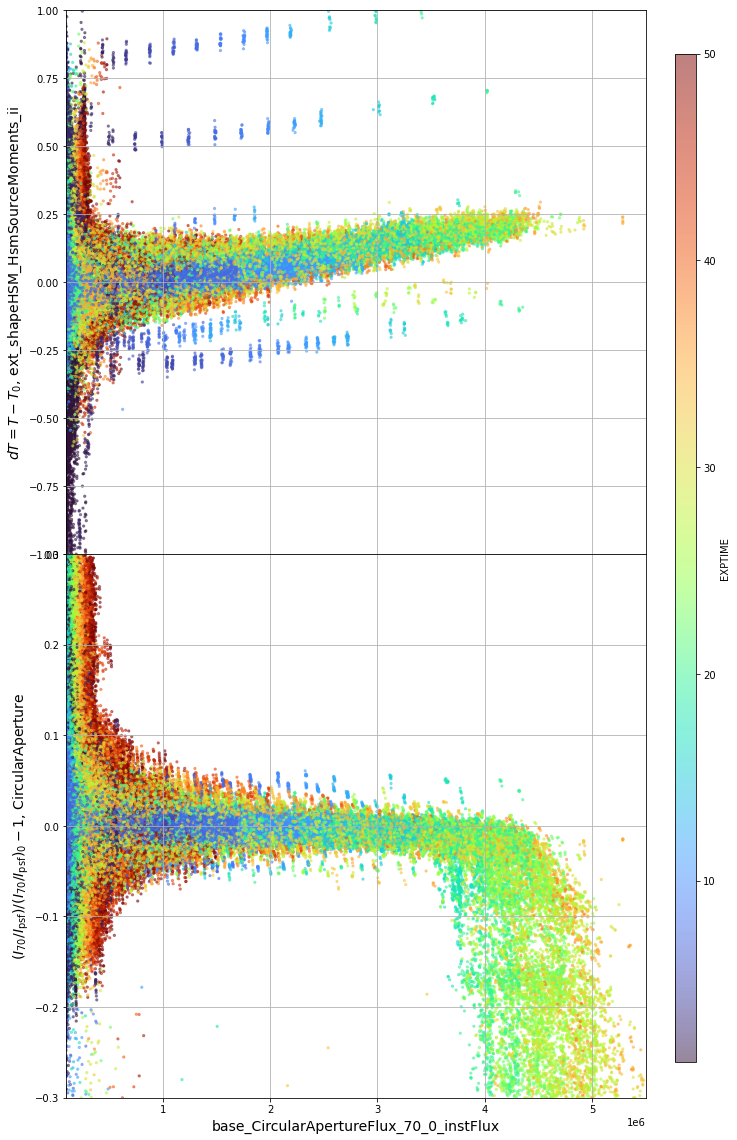

In [128]:
fig = plt.figure(figsize=(10,10),facecolor="white")

from astropy.table import vstack, join

y1key="ext_shapeHSM_HsmSourceMoments_xx"
y2key="ext_shapeHSM_HsmSourceMoments_yy"
#xkey="base_CircularApertureFlux_70_0_instFlux"
xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_3_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"
# ext_shapeHSM_HsmSourceMoments_xx
  
x = []
y = []
zl = []
zs = []
e = []
for aresult in results[:]:
    joined = join(aresult["src"].asAstropy(),ref,keys="spotgrid_index")
    Iperr = joined["base_PsfFlux_instFluxErr_1"]
    Ip = joined["base_PsfFlux_instFlux_1"]    
    Ierr = joined["{}Err_1".format(xkey)]
    I = joined["{}_1".format(xkey)]
    median=numpy.nanmedian(joined["base_CircularApertureFlux_70_0_instFlux_1"])
    joined = joined[
        numpy.where( 
#            (joined["base_PixelFlags_flag_1"] == False) &
#            (joined["base_PsfFlux_flag_edge_1"] == False) &
#            (joined["base_CircularApertureFlux_70_0_flag_apertureTruncated_1"] == False) &            
#            (joined["base_ClassificationExtendedness_flag_1"] == False) &
#            (joined["base_PixelFlags_flag_1"] == False) &            
#            (joined["base_PixelFlags_flag_offimage_1"] == False) &
#            (joined["base_PixelFlags_flag_edge_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolated_1"] == False) &
#            (joined["base_PixelFlags_flag_saturated_1"] == False) &            
#            (joined["base_PixelFlags_flag_cr_1"] == False) &
#            (joined["base_PixelFlags_flag_bad_1"] == False) &
#            (joined["base_PixelFlags_flag_suspect_1"] == False) &
#            (joined["base_PixelFlags_flag_interpolatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_saturatedCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_crCenter_1"] == False) &
#            (joined["base_PixelFlags_flag_suspectCenter_1"] == False) &
            ((joined["base_CircularApertureFlux_70_0_instFlux_1"]-median)/median<0.01)
#            (Iperr/Ip<0.01)&
#            (Ierr/I<0.01)            
        )
    ]
    x.extend(joined["{}_1".format(xkey)])
    Y1=joined["{}_1".format(y1key)]
    Y2=joined["{}_1".format(y2key)]
    Y0_1=joined["{}_2".format(y1key)]
    Y0_2=joined["{}_2".format(y2key)]    
    zl.extend(joined["{}_1".format(zlkey)]/joined["{}_2".format(zlkey)])
    zs.extend(joined["{}_1".format(zskey)]/joined["{}_2".format(zskey)])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([aresult["md"]["EXPTIME"]]*len(Y1))
    
x=numpy.array(x)
y=numpy.array(y)
zl=numpy.array(zl)
zs=numpy.array(zs)

fig = plt.figure(figsize=(10,20),facecolor="white")

ax = plt.subplot(211)
sca=ax.scatter(x,y,c=e,s=5,cmap='turbo',alpha=0.5)
ax.set_ylabel("{}".format(r"$dT=T-T_0$, ext_shapeHSM_HsmSourceMoments_ii"),fontsize=fontsize)
ax.set_xlim(1e5,1e7)
ax.set_ylim(-1,1)
ax.grid()

bx = plt.subplot(212,sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=5,cmap='turbo',alpha=0.5)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
bx.set_xlim(1e5,0.55e7)
bx.set_ylim(-.3,.3)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.93,hspace=0)

(array([  6,   7,   8,   9,  10,  13,  14,  15,  17,  22,  23,  28,  31,
        33,  36,  40,  42,  49,  50,  51,  54,  55,  56,  58,  64,  65,
        66,  68,  69,  71,  73,  76,  77,  80,  85,  89,  93,  95,  97,
        99, 100, 105, 109, 112, 114, 115, 117, 118, 120, 121, 122, 125,
       126, 127, 128, 130, 133, 134, 135, 139, 140, 141, 148, 150, 153,
       154, 155, 158, 160, 161, 164, 165, 166, 168, 169, 170, 173, 174,
       188, 189, 190, 191, 194, 197, 198, 204, 206, 207, 208, 209, 210,
       211, 218, 223, 224, 228, 229, 236, 240, 243, 246, 249, 255, 259,
       260, 261, 263, 265, 268, 269, 270, 272, 276, 277, 279, 280, 281,
       283, 284, 285, 289, 292, 295, 296, 298, 305, 307, 311, 315, 327,
       329, 331, 333, 335, 337, 338, 341, 346, 347, 349, 350, 355, 356,
       359, 361, 366, 367, 368, 369, 371, 372, 373, 380, 383, 384, 385,
       387, 388, 391, 392, 394, 397, 398, 402, 404, 405, 406, 408, 410,
       412, 413, 414, 415, 416, 419, 421, 428, 431, 434, 436, 4

Text(0.5, 0, 'EXPTIME [s]')

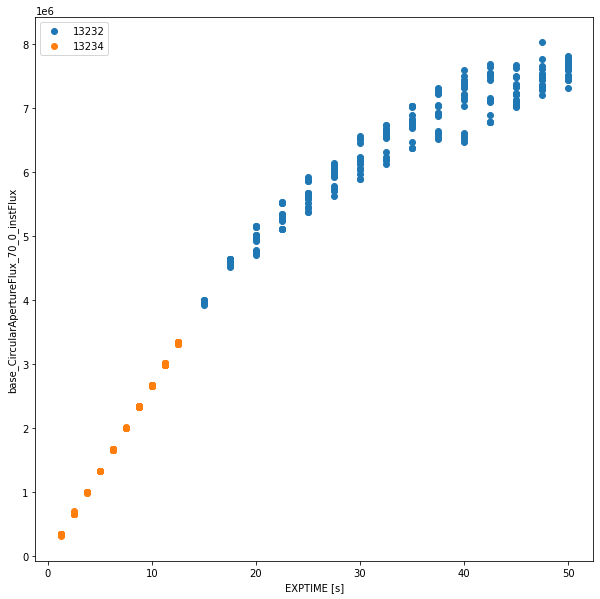

In [129]:
import pylab
fig = plt.figure(figsize=(10,10))

#for a in faint:
peak = []
exp = []
run = []
for b in results:
    peak.append(numpy.nanmax(b["src"]["base_CircularApertureFlux_70_0_instFlux"]))
    exp.append(b["md"]["EXPTIME"])
    run.append(b["md"]["RUNNUM"])

exp=numpy.array(exp)
peak=numpy.array(peak)
run=numpy.array(run)
for arun in list(set(run)):
    print(numpy.where(run == arun))
    pylab.plot(exp[numpy.where(run == arun)],peak[numpy.where(run == arun)],"o",label=arun)
pylab.legend()
pylab.ylabel("base_CircularApertureFlux_70_0_instFlux")
pylab.xlabel("EXPTIME [s]")

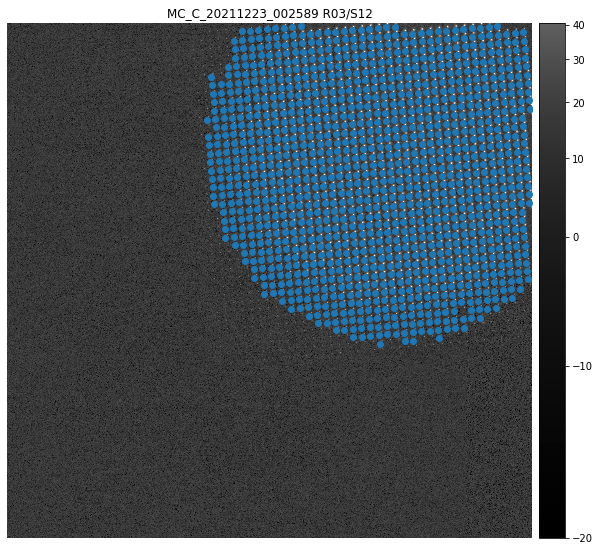

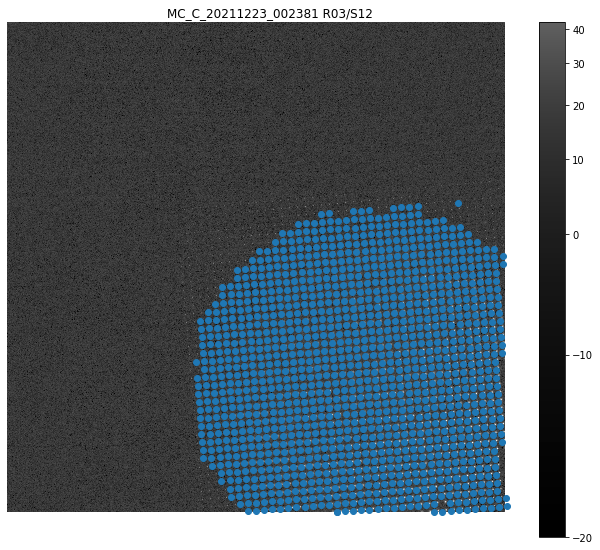

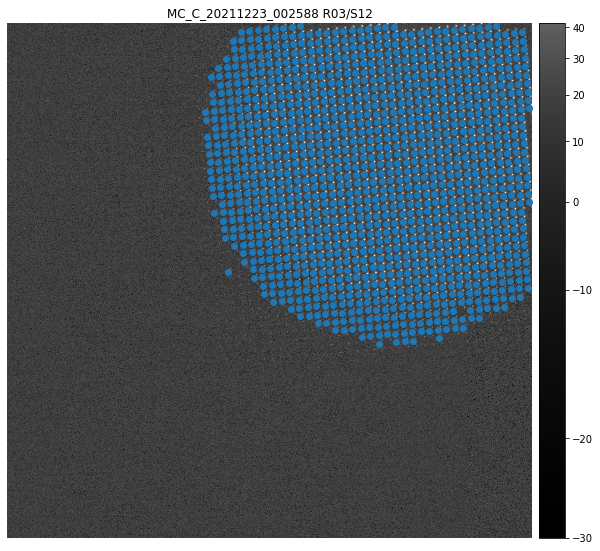

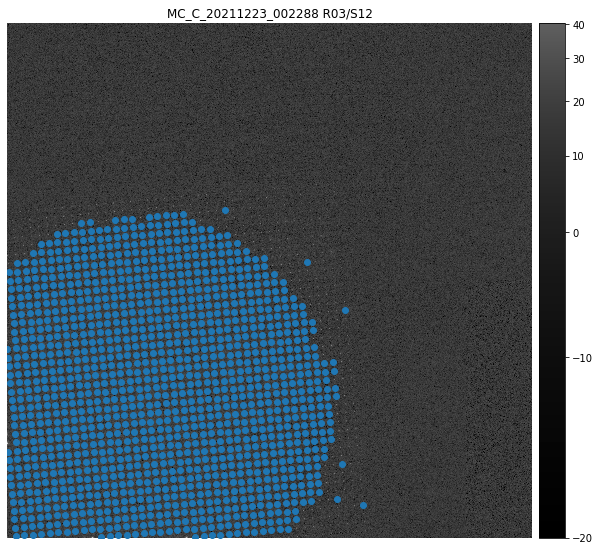

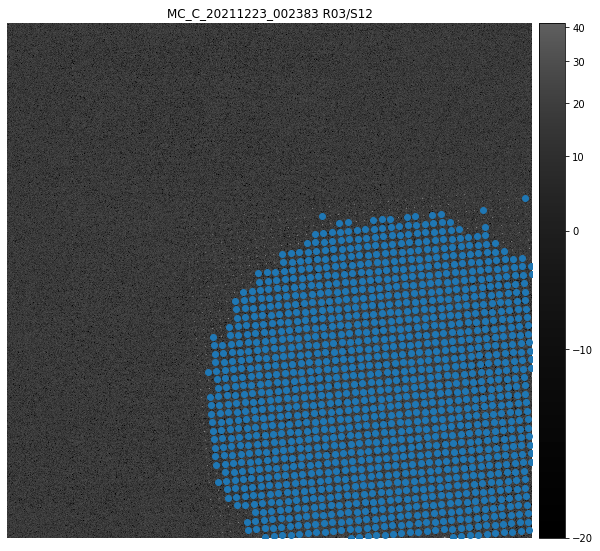

In [29]:
where = """
instrument='LSSTCam'
and detector=23
and exposure.observation_type = 'spot'
and exposure.exposure_time = 1.25
and exposure.science_program IN ('13232','13234')
"""

# gridSpotSrc

datasetRefs = list(subregistry.queryDatasets(
    datasetType="postISRCCD",
    collections=collections,
    where=where)
                  )
subresults = []

for aref in datasetRefs[:5]:
    try:
        # get a catalog from the butler
        raw = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
        img = raw.getImage().getArray()
#        print(src.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y","base_SdssShape_instFlux"])
        md = raw.getMetadata()
        x=src.asAstropy()["spotgrid_x"]
        y=src.asAstropy()["spotgrid_y"]
        I=src.asAstropy()["base_SdssShape_instFlux"]        
        display(raw)
        pylab.title(f"{md['OBSID']} {md['RAFTBAY']}/{md['CCDSLOT']}")
        pylab.plot(x,y,"o")        
        pylab.show()

        print(md["EXPTIME"])
        # stores into memory for later use
        subresults.append( {"md": md, "src":src} )
    except:
#        raise
        pass


In [ ]:
list(md)